# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 20.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=388447459dca2cd513a8228443d71a50f0156a6ec962de67618c97c35bb5f4cb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=ba55f18dc1c482dda3d2a0ec6ea01299f011b16824e8282bd6b5f9a7ad819c7a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c601

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 11.89 MiB/s, done.
Resolving deltas: 100% (3/3), done.


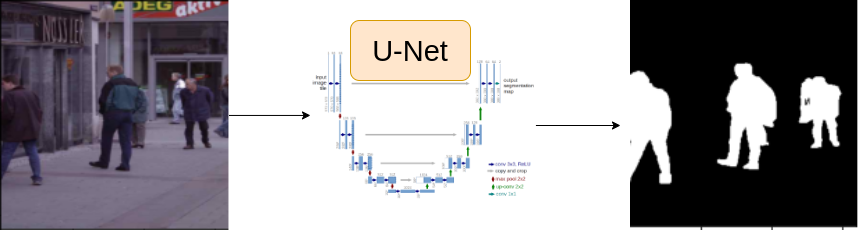

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'
DEVICE = 'cuda'

EPOCHS = 100
BATCH_SIZE = 16
IMAGE_SIZE = 320
LEARNING_RATE = 0.003

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.loc[4]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

print(f"Image Shape : {image.shape}")
print(f"Mask Shape : {mask.shape}")

Image Shape : (408, 612, 3)
Mask Shape : (408, 612)


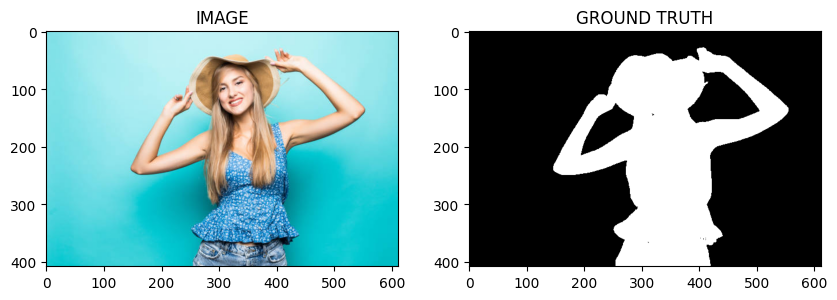

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
from albumentations import Compose, OneOf, HorizontalFlip, VerticalFlip, Rotate

def get_train_augs():
    return Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        Rotate(limit=45, p=0.5),
        # Try removing or adjusting the RandomCrop operation
        # RandomCrop(height=256, width=256, p=0.5),
    ])

def get_valid_augs():
    return Compose([
        # No augmentations for validation
    ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import torch

class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Ensure the mask has the same dimensions as the image
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    mask = np.expand_dims(mask, axis=-1)
    if self.augmentations:
      aug = self.augmentations(image=image, mask=mask)
      image = aug['image']
      mask = aug['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)
    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


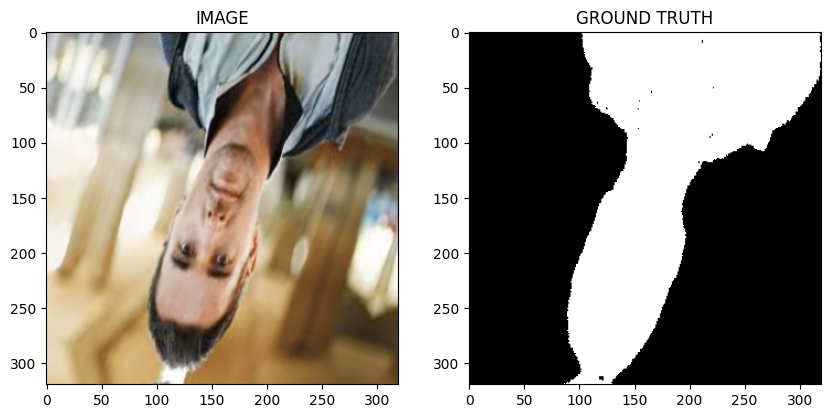

In [ ]:
idx = 32
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total number of batches in trainloader : {len(trainloader)}") #232/16~15, 232 is the length, and 16 is the given batch_size
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [ ]:
for image,mask in trainloader:
  print(f"Image batch shape : {image.shape}")
  print(f"Mask batch shape : {mask.shape}")
  break

Image batch shape : torch.Size([16, 3, 320, 320])
Mask batch shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

    self.loss_fn = DiceLoss(mode='binary')

  def forward(self, images, masks):
        logits = self.arc(images)
        if masks != None:
            loss1 = self.loss_fn(logits, masks)
            loss2 = torch.nn.BCEWithLogitsLoss()(logits, masks) # Use torch.nn directly
            loss = loss1 + loss2
            return logits, loss
        return logits



In [ ]:
model = SegmentationModel().to(DEVICE)

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss/len(data_loader) #avg loss

In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()
  return total_loss/len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
best_valid_loss = np.inf
for epoch in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)
  print(f"Epoch : {epoch+1}")
  print(f"Train Loss : {train_loss:.4f}")
  print(f"Valid Loss : {valid_loss:.4f}")
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pth')
    print('Saved Best Model!')

100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


Epoch : 1
Train Loss : 0.1893
Valid Loss : 0.2322
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Epoch : 2
Train Loss : 0.1715
Valid Loss : 0.1937
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch : 3
Train Loss : 0.1490
Valid Loss : 0.2594


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch : 4
Train Loss : 0.1497
Valid Loss : 0.2017


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch : 5
Train Loss : 0.1284
Valid Loss : 0.2285


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


Epoch : 6
Train Loss : 0.1596
Valid Loss : 0.1911
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


Epoch : 7
Train Loss : 0.1696
Valid Loss : 0.2269


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch : 8
Train Loss : 0.1327
Valid Loss : 0.1943


100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


Epoch : 9
Train Loss : 0.1306
Valid Loss : 0.1824
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Epoch : 10
Train Loss : 0.1200
Valid Loss : 0.1828


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Epoch : 11
Train Loss : 0.1353
Valid Loss : 0.2569


100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch : 12
Train Loss : 0.1122
Valid Loss : 0.2064


100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


Epoch : 13
Train Loss : 0.1058
Valid Loss : 0.1745
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


Epoch : 14
Train Loss : 0.1050
Valid Loss : 0.1987


100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Epoch : 15
Train Loss : 0.1178
Valid Loss : 0.2186


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch : 16
Train Loss : 0.1033
Valid Loss : 0.1818


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch : 17
Train Loss : 0.1066
Valid Loss : 0.1777


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch : 18
Train Loss : 0.1083
Valid Loss : 0.2160


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch : 19
Train Loss : 0.1227
Valid Loss : 0.1709
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch : 20
Train Loss : 0.1302
Valid Loss : 0.3180


100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


Epoch : 21
Train Loss : 0.1773
Valid Loss : 0.3111


100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Epoch : 22
Train Loss : 0.1730
Valid Loss : 0.2264


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Epoch : 23
Train Loss : 0.1536
Valid Loss : 0.2254


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Epoch : 24
Train Loss : 0.1449
Valid Loss : 0.1811


100%|██████████| 4/4 [00:00<00:00,  6.29it/s]


Epoch : 25
Train Loss : 0.1349
Valid Loss : 0.2270


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Epoch : 26
Train Loss : 0.1090
Valid Loss : 0.2278


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epoch : 27
Train Loss : 0.1263
Valid Loss : 0.2267


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Epoch : 28
Train Loss : 0.1138
Valid Loss : 0.1720


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch : 29
Train Loss : 0.1311
Valid Loss : 0.2312


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Epoch : 30
Train Loss : 0.1273
Valid Loss : 0.2680


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch : 31
Train Loss : 0.1211
Valid Loss : 0.2071


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


Epoch : 32
Train Loss : 0.0987
Valid Loss : 0.1815


100%|██████████| 4/4 [00:00<00:00,  6.16it/s]


Epoch : 33
Train Loss : 0.0941
Valid Loss : 0.1939


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Epoch : 34
Train Loss : 0.0952
Valid Loss : 0.2173


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Epoch : 35
Train Loss : 0.1277
Valid Loss : 0.2265


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch : 36
Train Loss : 0.1583
Valid Loss : 0.2535


100%|██████████| 4/4 [00:00<00:00,  6.18it/s]


Epoch : 37
Train Loss : 0.1389
Valid Loss : 0.2382


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch : 38
Train Loss : 0.1499
Valid Loss : 0.2462


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Epoch : 39
Train Loss : 0.1237
Valid Loss : 0.2283


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch : 40
Train Loss : 0.0960
Valid Loss : 0.2525


100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


Epoch : 41
Train Loss : 0.0945
Valid Loss : 0.2186


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch : 42
Train Loss : 0.1096
Valid Loss : 0.2202


100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch : 43
Train Loss : 0.1246
Valid Loss : 0.2355


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch : 44
Train Loss : 0.1450
Valid Loss : 0.2375


100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


Epoch : 45
Train Loss : 0.1292
Valid Loss : 0.1852


100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


Epoch : 46
Train Loss : 0.1589
Valid Loss : 0.2210


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch : 47
Train Loss : 0.1849
Valid Loss : 0.2048


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Epoch : 48
Train Loss : 0.1721
Valid Loss : 0.2450


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch : 49
Train Loss : 0.1712
Valid Loss : 0.2151


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch : 50
Train Loss : 0.1425
Valid Loss : 0.2582


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch : 51
Train Loss : 0.1154
Valid Loss : 0.2665


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


Epoch : 52
Train Loss : 0.1002
Valid Loss : 0.2497


100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


Epoch : 53
Train Loss : 0.0921
Valid Loss : 0.1844


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Epoch : 54
Train Loss : 0.0858
Valid Loss : 0.1723


100%|██████████| 4/4 [00:00<00:00,  6.03it/s]


Epoch : 55
Train Loss : 0.0862
Valid Loss : 0.1421
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch : 56
Train Loss : 0.0805
Valid Loss : 0.1767


100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


Epoch : 57
Train Loss : 0.0845
Valid Loss : 0.2019


100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


Epoch : 58
Train Loss : 0.0839
Valid Loss : 0.1925


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch : 59
Train Loss : 0.0888
Valid Loss : 0.1597


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Epoch : 60
Train Loss : 0.0869
Valid Loss : 0.1958


100%|██████████| 4/4 [00:00<00:00,  6.19it/s]


Epoch : 61
Train Loss : 0.0926
Valid Loss : 0.1711


100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


Epoch : 62
Train Loss : 0.0863
Valid Loss : 0.2708


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Epoch : 63
Train Loss : 0.0946
Valid Loss : 0.2326


100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


Epoch : 64
Train Loss : 0.0942
Valid Loss : 0.1984


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch : 65
Train Loss : 0.0949
Valid Loss : 0.1926


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch : 66
Train Loss : 0.0952
Valid Loss : 0.1753


100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


Epoch : 67
Train Loss : 0.0976
Valid Loss : 0.2017


100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch : 68
Train Loss : 0.0875
Valid Loss : 0.2258


100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


Epoch : 69
Train Loss : 0.0853
Valid Loss : 0.1950


100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Epoch : 70
Train Loss : 0.0831
Valid Loss : 0.1674


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


Epoch : 71
Train Loss : 0.0946
Valid Loss : 0.2168


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


Epoch : 72
Train Loss : 0.0914
Valid Loss : 0.2668


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Epoch : 73
Train Loss : 0.0873
Valid Loss : 0.2342


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch : 74
Train Loss : 0.0842
Valid Loss : 0.2143


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Epoch : 75
Train Loss : 0.0868
Valid Loss : 0.1660


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch : 76
Train Loss : 0.0769
Valid Loss : 0.2345


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Epoch : 77
Train Loss : 0.0734
Valid Loss : 0.2119


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch : 78
Train Loss : 0.0704
Valid Loss : 0.2040


100%|██████████| 4/4 [00:00<00:00,  6.21it/s]


Epoch : 79
Train Loss : 0.0757
Valid Loss : 0.1918


100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Epoch : 80
Train Loss : 0.0750
Valid Loss : 0.1787


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Epoch : 81
Train Loss : 0.0679
Valid Loss : 0.2109


100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Epoch : 82
Train Loss : 0.0663
Valid Loss : 0.2094


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Epoch : 83
Train Loss : 0.0645
Valid Loss : 0.1953


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch : 84
Train Loss : 0.0638
Valid Loss : 0.1997


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 85
Train Loss : 0.0642
Valid Loss : 0.1995


100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Epoch : 86
Train Loss : 0.0584
Valid Loss : 0.1977


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


Epoch : 87
Train Loss : 0.0607
Valid Loss : 0.2053


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch : 88
Train Loss : 0.0832
Valid Loss : 0.4449


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Epoch : 89
Train Loss : 0.1024
Valid Loss : 0.2116


100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Epoch : 90
Train Loss : 0.1278
Valid Loss : 0.2406


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Epoch : 91
Train Loss : 0.1304
Valid Loss : 0.2515


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch : 92
Train Loss : 0.1141
Valid Loss : 0.1644


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Epoch : 93
Train Loss : 0.1153
Valid Loss : 0.1868


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Epoch : 94
Train Loss : 0.0918
Valid Loss : 0.2095


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch : 95
Train Loss : 0.0927
Valid Loss : 0.2001


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Epoch : 96
Train Loss : 0.0771
Valid Loss : 0.2267


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch : 97
Train Loss : 0.0738
Valid Loss : 0.2081


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Epoch : 98
Train Loss : 0.0758
Valid Loss : 0.2540


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Epoch : 99
Train Loss : 0.0747
Valid Loss : 0.1942


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]

Epoch : 100
Train Loss : 0.0717
Valid Loss : 0.1900


# Task 9 : Inference

<ipython-input-61-114a62685c7f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pth'))


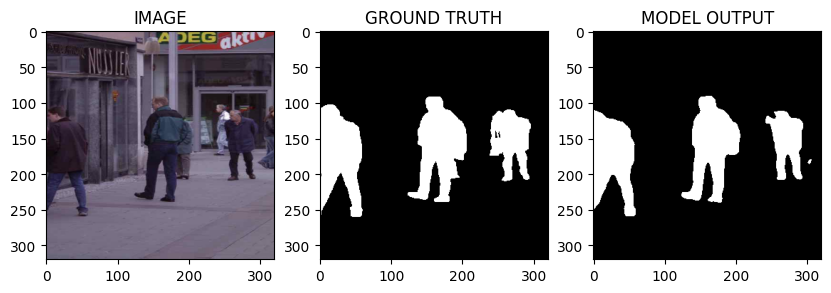

In [ ]:
idx = np.random.randint(0, len(validset))
idx = 20
image, mask = validset[idx]

model.load_state_dict(torch.load('/content/best_model.pth'))

logits_mask = model(image.to(DEVICE).unsqueeze(0), masks=None) # Add masks=None as an argument.
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0
pred_mask = pred_mask.detach().cpu().squeeze(0)

helper.show_image(image, mask, pred_mask)

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 17.4 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Dice, JaccardIndex
def calculate_metrics(pred_mask, true_mask):
    dice_metric = Dice(average='micro').to(DEVICE)
    iou_metric = JaccardIndex(task='binary', num_classes=1).to(DEVICE)

    dice_score = dice_metric(pred_mask, true_mask)
    iou_score = iou_metric(pred_mask, true_mask)

    return dice_score.item(), iou_score.item()

In [ ]:
def inference_with_metrics(model, data_loader):
    model.eval()
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE).long() # Convert mask to long tensor

            logits = model(images, masks=None)
            pred_masks = (torch.sigmoid(logits) > 0.5).float()

            dice_score, iou_score = calculate_metrics(pred_masks, masks)
            dice_scores.append(dice_score)
            iou_scores.append(iou_score)

    avg_dice = sum(dice_scores) / len(dice_scores)
    avg_iou = sum(iou_scores) / len(iou_scores)
    return avg_dice, avg_iou

In [ ]:
# After training, load the best model and calculate metrics
model.load_state_dict(torch.load('best_model.pth'))
model.to(DEVICE)

print("Calculating metrics on validation set...")
val_dice, val_iou = inference_with_metrics(model, validloader)
print(f"Validation Dice Score: {val_dice:.4f}")
print(f"Validation IoU Score: {val_iou:.4f}")

# Optional: Calculate metrics on training set as well
print("Calculating metrics on training set...")
train_dice, train_iou = inference_with_metrics(model, trainloader)
print(f"Training Dice Score: {train_dice:.4f}")
print(f"Training IoU Score: {train_iou:.4f}")

<ipython-input-75-34fae80e3ef2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Calculating metrics on validation set...


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


Validation Dice Score: 0.9535
Validation IoU Score: 0.9112
Calculating metrics on training set...


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]

Training Dice Score: 0.9729
Training IoU Score: 0.9472


In [ ]:
from torchmetrics import Dice, JaccardIndex
from torchmetrics.classification import BinaryPrecision, BinaryRecall, BinaryF1Score

# ... [SegmentationModel class and other functions remain the same] ...

def calculate_metrics(pred_mask, true_mask):
    # Use 'micro' for overall Dice score or 'macro' for average per-class Dice
    dice_metric = Dice(average='micro', num_classes=2).to(DEVICE)
    iou_metric = JaccardIndex(task='binary', num_classes=2).to(DEVICE)
    precision_metric = BinaryPrecision().to(DEVICE)
    recall_metric = BinaryRecall().to(DEVICE)
    f1_metric = BinaryF1Score().to(DEVICE)

    dice_score = dice_metric(pred_mask, true_mask)
    iou_score = iou_metric(pred_mask, true_mask)
    precision = precision_metric(pred_mask, true_mask)
    recall = recall_metric(pred_mask, true_mask)
    f1 = f1_metric(pred_mask, true_mask)

    return {
        'dice': dice_score.tolist(),
        'iou': iou_score.tolist(),
        'precision': precision.item(),
        'recall': recall.item(),
        'f1': f1.item()
    }

def inference_with_metrics(model, data_loader):
    model.eval()
    all_metrics = []

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE).long()  # Convert mask to long tensor

            logits = model(images, masks=None)
            pred_masks = (torch.sigmoid(logits) > 0.5).float()

            metrics = calculate_metrics(pred_masks, masks)
            all_metrics.append(metrics)

    # Calculate average metrics
    avg_metrics = {
        'dice': [sum(m['dice'][i] for m in all_metrics) / len(all_metrics) for i in range(2)],
        'iou': [sum(m['iou'][i] for m in all_metrics) / len(all_metrics) for i in range(2)],
        'precision': sum(m['precision'] for m in all_metrics) / len(all_metrics),
        'recall': sum(m['recall'] for m in all_metrics) / len(all_metrics),
        'f1': sum(m['f1'] for m in all_metrics) / len(all_metrics)
    }

    return avg_metrics

In [ ]:
# After training, load the best model and calculate metrics
model.load_state_dict(torch.load('best_model.pth'))
model.to(DEVICE)

print("Calculating metrics on validation set...")
val_metrics = inference_with_metrics(model, validloader)
print("Validation Metrics:")
print(f"Dice Score: Background: {val_metrics['dice'][0]:.4f}, Foreground: {val_metrics['dice'][1]:.4f}")
print(f"IoU Score: Background: {val_metrics['iou'][0]:.4f}, Foreground: {val_metrics['iou'][1]:.4f}")
print(f"Precision: {val_metrics['precision']:.4f}")
print(f"Recall: {val_metrics['recall']:.4f}")
print(f"F1 Score: {val_metrics['f1']:.4f}")

# Optional: Calculate metrics on training set as well
print("\nCalculating metrics on training set...")
train_metrics = inference_with_metrics(model, trainloader)
print("Training Metrics:")
print(f"Dice Score: Background: {train_metrics['dice'][0]:.4f}, Foreground: {train_metrics['dice'][1]:.4f}")
print(f"IoU Score: Background: {train_metrics['iou'][0]:.4f}, Foreground: {train_metrics['iou'][1]:.4f}")
print(f"Precision: {train_metrics['precision']:.4f}")
print(f"Recall: {train_metrics['recall']:.4f}")
print(f"F1 Score: {train_metrics['f1']:.4f}")

<ipython-input-81-77d28cba8f4d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Calculating metrics on validation set...


  0%|          | 0/4 [00:00<?, ?it/s]


ValueError: The implied number of classes (from shape of inputs) does not match num_classes.

In [ ]:
from torchmetrics import Dice, JaccardIndex
from torchmetrics.classification import BinaryPrecision, BinaryRecall, BinaryF1Score

# ... [SegmentationModel class and other functions remain the same] ...

def calculate_metrics(pred_mask, true_mask):
    # Use 'micro' for overall Dice score or 'macro' for average per-class Dice
    dice_metric = Dice(average='micro').to(DEVICE) # num_classes should be removed for binary segmentation
    iou_metric = JaccardIndex(task='binary').to(DEVICE) # num_classes should be removed for binary segmentation
    precision_metric = BinaryPrecision().to(DEVICE)
    recall_metric = BinaryRecall().to(DEVICE)
    f1_metric = BinaryF1Score().to(DEVICE)

    dice_score = dice_metric(pred_mask, true_mask)
    iou_score = iou_metric(pred_mask, true_mask)
    precision = precision_metric(pred_mask, true_mask)
    recall = recall_metric(pred_mask, true_mask)
    f1 = f1_metric(pred_mask, true_mask)

    return {
        'dice': dice_score.tolist(),
        'iou': iou_score.tolist(),
        'precision': precision.item(),
        'recall': recall.item(),
        'f1': f1.item()
    }

def inference_with_metrics(model, data_loader):
    model.eval()
    all_metrics = []

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE).long()  # Convert mask to long tensor

            logits = model(images, masks=None)
            pred_masks = (torch.sigmoid(logits) > 0.5).float()

            metrics = calculate_metrics(pred_masks, masks)
            all_metrics.append(metrics)

    # Calculate average metrics
    avg_metrics = {
        'dice': sum(m['dice'] for m in all_metrics) / len(all_metrics), # removed indexing since dice is now a single value
        'iou': sum(m['iou'] for m in all_metrics) / len(all_metrics), # removed indexing since iou is now a single value
        'precision': sum(m['precision'] for m in all_metrics) / len(all_metrics),
        'recall': sum(m['recall'] for m in all_metrics) / len(all_metrics),
        'f1': sum(m['f1'] for m in all_metrics) / len(all_metrics)
    }

    return avg_metrics

In [ ]:
# After training, load the best model and calculate metrics
model.load_state_dict(torch.load('best_model.pth'))
model.to(DEVICE)

print("Calculating metrics on validation set...")
val_metrics = inference_with_metrics(model, validloader)
print("Validation Metrics:")
print(f"Dice Score: Background: {val_metrics['dice'][0]:.4f}, Foreground: {val_metrics['dice'][1]:.4f}")
print(f"IoU Score: Background: {val_metrics['iou'][0]:.4f}, Foreground: {val_metrics['iou'][1]:.4f}")
print(f"Precision: {val_metrics['precision']:.4f}")
print(f"Recall: {val_metrics['recall']:.4f}")
print(f"F1 Score: {val_metrics['f1']:.4f}")

# Optional: Calculate metrics on training set as well
print("\nCalculating metrics on training set...")
train_metrics = inference_with_metrics(model, trainloader)
print("Training Metrics:")
print(f"Dice Score: Background: {train_metrics['dice'][0]:.4f}, Foreground: {train_metrics['dice'][1]:.4f}")
print(f"IoU Score: Background: {train_metrics['iou'][0]:.4f}, Foreground: {train_metrics['iou'][1]:.4f}")
print(f"Precision: {train_metrics['precision']:.4f}")
print(f"Recall: {train_metrics['recall']:.4f}")
print(f"F1 Score: {train_metrics['f1']:.4f}")

<ipython-input-83-77d28cba8f4d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Calculating metrics on validation set...


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

Validation Metrics:


TypeError: 'float' object is not subscriptable

In [ ]:
# After training, load the best model and calculate metrics
model.load_state_dict(torch.load('best_model.pth'))
model.to(DEVICE)

print("Calculating metrics on validation set...")
val_metrics = inference_with_metrics(model, validloader)
print("Validation Metrics:")
print(f"Dice Score: {val_metrics['dice']:.4f}") # Changed to output a single dice score
print(f"IoU Score: {val_metrics['iou']:.4f}") # Changed to output a single iou score
print(f"Precision: {val_metrics['precision']:.4f}")
print(f"Recall: {val_metrics['recall']:.4f}")
print(f"F1 Score: {val_metrics['f1']:.4f}")

# Optional: Calculate metrics on training set as well
print("\nCalculating metrics on training set...")
train_metrics = inference_with_metrics(model, trainloader)
print("Training Metrics:")
print(f"Dice Score: {train_metrics['dice']:.4f}") # Changed to output a single dice score
print(f"IoU Score: {train_metrics['iou']:.4f}") # Changed to output a single iou score
print(f"Precision: {train_metrics['precision']:.4f}")
print(f"Recall: {train_metrics['recall']:.4f}")
print(f"F1 Score: {train_metrics['f1']:.4f}")

<ipython-input-84-f01afbcc3bcc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Calculating metrics on validation set...


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


Validation Metrics:
Dice Score: 0.9535
IoU Score: 0.9112
Precision: 0.9591
Recall: 0.9482
F1 Score: 0.9535

Calculating metrics on training set...


100%|██████████| 15/15 [00:02<00:00,  5.02it/s]

Training Metrics:
Dice Score: 0.9729
IoU Score: 0.9474
Precision: 0.9777
Recall: 0.9683
F1 Score: 0.9729
